<a href="https://colab.research.google.com/github/kumar-abhishek/imbalanced-machine-learning-book/blob/main/random/Coding_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use python 3.9.8 64 bit

In [1]:
# %%capture
# !pip3 install imbalanced-learn==0.9.1 xgboost==1.6.1 pandas==1.4.3 matplotlib==3.1.3 seaborn==0.11.2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

## Synthetic data set prep:

In [3]:
def make_data(sep):
    X, y = make_classification(n_samples=5000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.995],
                           class_sep=sep,# how separate the classes are
                           random_state=1)
    
    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns =['feature_1', 'feature_2'])
    y = pd.Series(y)
    
    return X, y

0    4950
1      50
dtype: int64


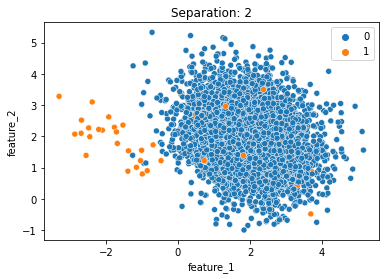

0    4950
1      50
dtype: int64


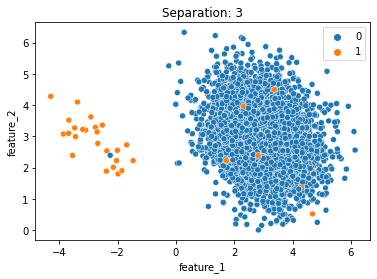

In [4]:
# make datasets with different class separateness
# and plot
synthetic_datasets = []
for sep in [2, 3]:
    X, y = make_data(sep)
    synthetic_datasets.append({'data': np.array(X), 'target': np.array(y), 'DESCR': 'synthetic data, sep: ' + str(sep)})
    print(y.value_counts()) 
    sns.scatterplot(
        data=X, x="feature_1", y="feature_2", hue=y
    )
    plt.title('Separation: {}'.format(sep))
    plt.show()

## Real world data set

In [5]:
# Abalone dataset, and thyroid dataset 
from imblearn.datasets import fetch_datasets

# these datasets are baked into imbalanced-learn
dataset_list = [
    'thyroid_sick',
    'abalone_19'
]

In [6]:
# print class imbalance of each dataset
from collections import Counter
from sklearn.preprocessing import LabelEncoder

all_datasets = []
all_datasets = synthetic_datasets
le = LabelEncoder()
for dataset in dataset_list:
    data = fetch_datasets()[dataset]
    data['target'] = le.fit_transform(data['target'])
    all_datasets.append(data)

for item in all_datasets:
  print(Counter(item['target']))


Counter({0: 4950, 1: 50})
Counter({0: 4950, 1: 50})
Counter({0: 3541, 1: 231})
Counter({0: 4145, 1: 32})


In [7]:
# function to train random forests and evaluate the performance
from numpy import mean
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

scaler = MinMaxScaler()

def run_model(classifier, X_train, y_train, undersampler=None):
    model = Pipeline(steps=[('minMaxScaling', scaler), ('under', undersampler), ('model', classifier)])
    
    folds = RepeatedStratifiedKFold(n_splits=15, n_repeats=3, random_state=1)
    cv_results = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=folds, n_jobs=-1)
    print("model: ", type(classifier).__name__, " | cv_results:", mean(cv_results))
    return mean(cv_results)

In [8]:
from imblearn.under_sampling import (
    AllKNN,
    CondensedNearestNeighbour,
    EditedNearestNeighbours,
    InstanceHardnessThreshold,
    OneSidedSelection,
    RandomUnderSampler,
    NearMiss,
    NeighbourhoodCleaningRule,
    RepeatedEditedNearestNeighbours,
    TomekLinks,
)

from imblearn.combine import SMOTEENN, SMOTETomek

undersampler_map = {
    'Nosampling': None,
    
    'RandomUnderSampler': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    
    'condNearNeigh': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=4),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'renn': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        max_iter=100),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'ncr': NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        threshold_cleaning=0.5),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=4),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=4),

    'insTh': InstanceHardnessThreshold(
        estimator=LogisticRegression(random_state=0),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=4,
        cv=3),

    'SMOTEENN': SMOTEENN(random_state=0),

    'SMOTETomek': SMOTETomek(random_state=0)
}

In [9]:
# now we train several models, with the different UnderSampling techniques and
# with cross-validation for each dataset

# save results
pr_mean_dict_lr = {}
pr_mean_dict_xgb = {}

for data in all_datasets:
    pr_mean_dict_lr[data['DESCR']] = {} 
    pr_mean_dict_xgb[data['DESCR']] = {}

    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data['data'],  
        data['target'], 
        test_size=0.3,
        random_state=0,
    )
    
    for undersampler in undersampler_map.keys():
        print(undersampler, ' | Dataset description: ', data['DESCR'])
        # set up the classifier
        lr = LogisticRegression(random_state=0, max_iter=10000)
        aps_mean_lr = run_model(lr, X_train, y_train, undersampler_map[undersampler])
        pr_mean_dict_lr[data['DESCR']][undersampler] = aps_mean_lr

        xgb = XGBClassifier()
        aps_mean_xgb = run_model(xgb, X_train, y_train, undersampler_map[undersampler])
        pr_mean_dict_xgb[data['DESCR']][undersampler] = aps_mean_xgb

        print()

Nosampling  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.766301285985194
model:  XGBClassifier  | cv_results: 0.7379070881226053

RandomUnderSampler  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.7729509103072322
model:  XGBClassifier  | cv_results: 0.7382841828244127

condNearNeigh  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.766844346585726
model:  XGBClassifier  | cv_results: 0.6866953262786596

tomek  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.766301285985194
model:  XGBClassifier  | cv_results: 0.7410305849961022

oss  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.7648582845421927
model:  XGBClassifier  | cv_results: 0.7431329579318086

enn  | Dataset description:  synthetic data, sep: 2
model:  LogisticRegression  | cv_results: 0.7662215338939476
model:

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


model:  LogisticRegression  | cv_results: 0.9197089920748189
model:  XGBClassifier  | cv_results: 0.9943744491280089

oss  | Dataset description:  thyroid_sick
model:  LogisticRegression  | cv_results: 0.9188870080874462
model:  XGBClassifier  | cv_results: 0.9941881760282636

enn  | Dataset description:  thyroid_sick
model:  LogisticRegression  | cv_results: 0.9160263459715815
model:  XGBClassifier  | cv_results: 0.9921555090886964

renn  | Dataset description:  thyroid_sick
model:  LogisticRegression  | cv_results: 0.9109947226924227
model:  XGBClassifier  | cv_results: 0.9918257419024124

allknn  | Dataset description:  thyroid_sick
model:  LogisticRegression  | cv_results: 0.9138731971043035
model:  XGBClassifier  | cv_results: 0.9919393644366263

ncr  | Dataset description:  thyroid_sick
model:  LogisticRegression  | cv_results: 0.9144267796622673
model:  XGBClassifier  | cv_results: 0.9931569067823176

nm1  | Dataset description:  thyroid_sick
model:  LogisticRegression  | cv_res

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


model:  LogisticRegression  | cv_results: 0.9388821032523111


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


model:  XGBClassifier  | cv_results: 0.9896342394370872

SMOTETomek  | Dataset description:  thyroid_sick


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


model:  LogisticRegression  | cv_results: 0.9455201153558219


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


model:  XGBClassifier  | cv_results: 0.9910736425960961

Nosampling  | Dataset description:  abalone_19
model:  LogisticRegression  | cv_results: 0.6726255126447422
model:  XGBClassifier  | cv_results: 0.7528351999240306

RandomUnderSampler  | Dataset description:  abalone_19
model:  LogisticRegression  | cv_results: 0.6551460332722018
model:  XGBClassifier  | cv_results: 0.773415771949504

condNearNeigh  | Dataset description:  abalone_19
model:  LogisticRegression  | cv_results: 0.4491640403824582
model:  XGBClassifier  | cv_results: 0.512728130619803

tomek  | Dataset description:  abalone_19
model:  LogisticRegression  | cv_results: 0.6726261061552979
model:  XGBClassifier  | cv_results: 0.7486177139160421

oss  | Dataset description:  abalone_19
model:  LogisticRegression  | cv_results: 0.6788271044400523
model:  XGBClassifier  | cv_results: 0.7589468748701694

enn  | Dataset description:  abalone_19
model:  LogisticRegression  | cv_results: 0.6722836505647253
model:  XGBClassifie

In [10]:
from IPython.display import display
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("\033[1m Logistic Regression, Mean AUC")
df_lr = pd.DataFrame(pr_mean_dict_lr).T
display(df_lr)
print('\n')


print("\033[1m XGBoost Classifier, Mean AUC")
df_xgb = pd.DataFrame(pr_mean_dict_xgb).T
display(df_xgb)


 Logistic Regression, Mean AUC


,Nosampling,RandomUnderSampler,condNearNeigh,tomek,oss,enn,renn,allknn,ncr,nm1,nm2,insTh,SMOTEENN,SMOTETomek
"synthetic data, sep: 2",0.766301,0.772951,0.766844,0.766301,0.764858,0.766222,0.766173,0.766205,0.766157,0.741307,0.585374,0.757917,0.775443,0.781472
"synthetic data, sep: 3",0.766365,0.774170,0.771058,0.766381,0.765114,0.766334,0.766301,0.766238,0.766285,0.743278,0.771542,0.758094,0.769147,0.778124
thyroid_sick,0.920264,0.898496,0.919074,0.919709,0.918887,0.916026,0.910995,0.913873,0.914427,0.417236,0.544156,0.857905,0.938882,0.945520
abalone_19,0.672626,0.655146,0.449164,0.672626,0.678827,0.672284,0.672628,0.672685,0.672453,0.528768,0.642197,0.654893,0.832991,0.831902




 XGBoost Classifier, Mean AUC


,Nosampling,RandomUnderSampler,condNearNeigh,tomek,oss,enn,renn,allknn,ncr,nm1,nm2,insTh,SMOTEENN,SMOTETomek
"synthetic data, sep: 2",0.737907,0.738284,0.686695,0.741031,0.743133,0.746836,0.746255,0.751121,0.745623,0.744875,0.444854,0.481446,0.728585,0.722007
"synthetic data, sep: 3",0.750715,0.741821,0.745359,0.750132,0.752592,0.751393,0.748175,0.747066,0.748707,0.741327,0.275692,0.484519,0.747119,0.749515
thyroid_sick,0.994000,0.986393,0.987892,0.994374,0.994188,0.992156,0.991826,0.991939,0.993157,0.955256,0.908303,0.907034,0.989634,0.991074
abalone_19,0.752835,0.773416,0.512728,0.748618,0.758947,0.752202,0.753924,0.761711,0.746356,0.548384,0.424298,0.553633,0.746307,0.743769


Points to note:
1. Please note that the models used here are not tuned with the best hyperparameters. 
Tuning XGBoost parameters would likely make it better than logistic regression here (for example, try with hyperparameters of {'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.2})

                      lr   xgb
Nosampling          0.77  0.74
RandomUnderSampler  0.77  0.74
condNearNeigh       0.77  0.69
tomek               0.77  0.74
oss                 0.76  0.74
enn                 0.77  0.75
renn                0.77  0.75
allknn              0.77  0.75
ncr                 0.77  0.75
nm1                 0.74  0.74
nm2                 0.59  0.44
insTh               0.76  0.48
SMOTEENN            0.78  0.73
SMOTETomek          0.78  0.72


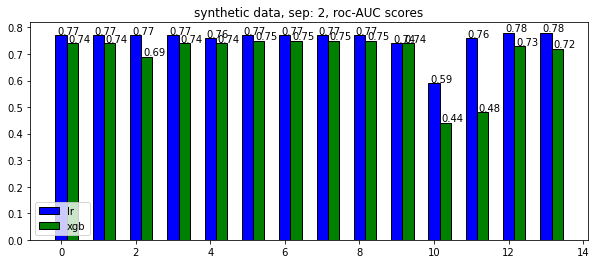

----------------------------------------------------------------

                      lr   xgb
Nosampling          0.77  0.75
RandomUnderSampler  0.77  0.74
condNearNeigh       0.77  0.75
tomek               0.77  0.75
oss                 0.77  0.75
enn                 0.77  0.75
renn                0.77  0.75
allknn              0.77  0.75
ncr                 0.77  0.75
nm1                 0.74  0.74
nm2                 0.77  0.28
insTh               0.76  0.48
SMOTEENN            0.77  0.75
SMOTETomek          0.78  0.75


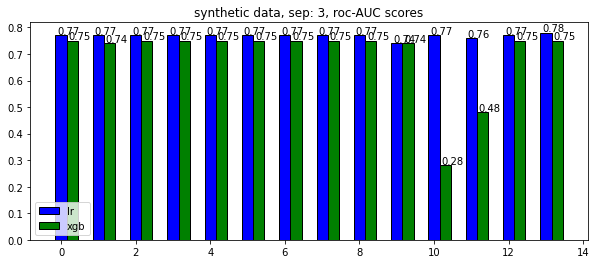

----------------------------------------------------------------

                      lr   xgb
Nosampling          0.92  0.99
RandomUnderSampler  0.90  0.99
condNearNeigh       0.92  0.99
tomek               0.92  0.99
oss                 0.92  0.99
enn                 0.92  0.99
renn                0.91  0.99
allknn              0.91  0.99
ncr                 0.91  0.99
nm1                 0.42  0.96
nm2                 0.54  0.91
insTh               0.86  0.91
SMOTEENN            0.94  0.99
SMOTETomek          0.95  0.99


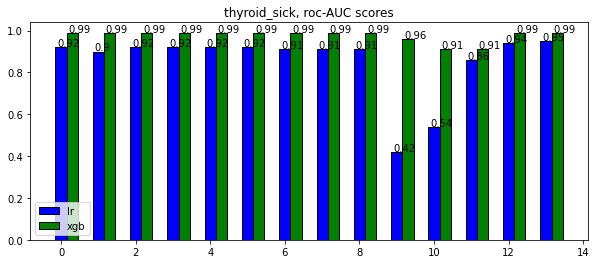

----------------------------------------------------------------

                      lr   xgb
Nosampling          0.67  0.75
RandomUnderSampler  0.66  0.77
condNearNeigh       0.45  0.51
tomek               0.67  0.75
oss                 0.68  0.76
enn                 0.67  0.75
renn                0.67  0.75
allknn              0.67  0.76
ncr                 0.67  0.75
nm1                 0.53  0.55
nm2                 0.64  0.42
insTh               0.65  0.55
SMOTEENN            0.83  0.75
SMOTETomek          0.83  0.74


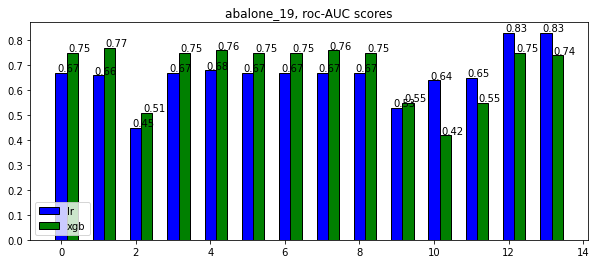

----------------------------------------------------------------



In [11]:
# Now we plot the performance of the model in the 
for (i, dataset) in enumerate(all_datasets):
    pr_mean_s_lr = pd.Series(pr_mean_dict_lr[dataset['DESCR']]).round(2)
    pr_mean_s_xgb = pd.Series(pr_mean_dict_xgb[dataset['DESCR']]).round(2)
    df = pd.DataFrame([pr_mean_s_lr, pr_mean_s_xgb], index=['lr' ,'xgb']).T
    print(df)

    r = np.arange(14) # plotting for 14 different undersampling techniques
    
    # plotting logistic regression scores
    plt.figure(figsize=(10, 4))
    bars = plt.bar(r, df['lr'], color = 'b',
                   width = .3, edgecolor = 'black',
                   label='lr')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x()+0.05, yval + .005, yval)
    
    # plotting XGBoost scores
    bars = plt.bar(r+0.3, df['xgb'], color = 'g',
                   width = .3, edgecolor = 'black',
                   label='xgb')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x()+0.05, yval + .005, yval)
    plt.legend(loc="lower left")
    plt.title("%s, roc-AUC scores"%(all_datasets[i]["DESCR"]))
    plt.show()
    print("----------------------------------------------------------------\n")